In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (180, 180)
batch_size = 32
epochs = 45

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "..\images\Massas",
    validation_split=0.3,
    subset="both",
    color_mode="rgb",
    seed=1212,
    image_size=image_size,
    batch_size=batch_size,
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


# ## Build a model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)


# ## Train the model

model.compile(
    optimizer=keras.optimizers.Adam(1e-6),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

Found 1696 files belonging to 2 classes.
Using 1188 files for training.
Using 508 files for validation.


In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [3]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/45
38/38 [==============================] - 116s 3s/step - loss: 0.7508 - accuracy: 0.4680 - val_loss: 0.6932 - val_accuracy: 0.6201
Epoch 2/45
38/38 [==============================] - 107s 3s/step - loss: 0.6847 - accuracy: 0.5564 - val_loss: 0.6933 - val_accuracy: 0.3799
Epoch 3/45
38/38 [==============================] - 102s 3s/step - loss: 0.6288 - accuracy: 0.6406 - val_loss: 0.6936 - val_accuracy: 0.3799
Epoch 4/45
38/38 [==============================] - 103s 3s/step - loss: 0.5833 - accuracy: 0.6970 - val_loss: 0.6942 - val_accuracy: 0.3799
Epoch 5/45
38/38 [==============================] - 103s 3s/step - loss: 0.5370 - accuracy: 0.7643 - val_loss: 0.6953 - val_accuracy: 0.3799
Epoch 6/45
38/38 [==============================] - 103s 3s/step - loss: 0.4978 - accuracy: 0.8064 - val_loss: 0.6971 - val_accuracy: 0.3799
Epoch 7/45
38/38 [==============================] - 106s 3s/step - loss: 0.4589 - accuracy: 0.8409 - val_loss: 0.6997 - val_accuracy: 0.3799
Epoch 8/45
38

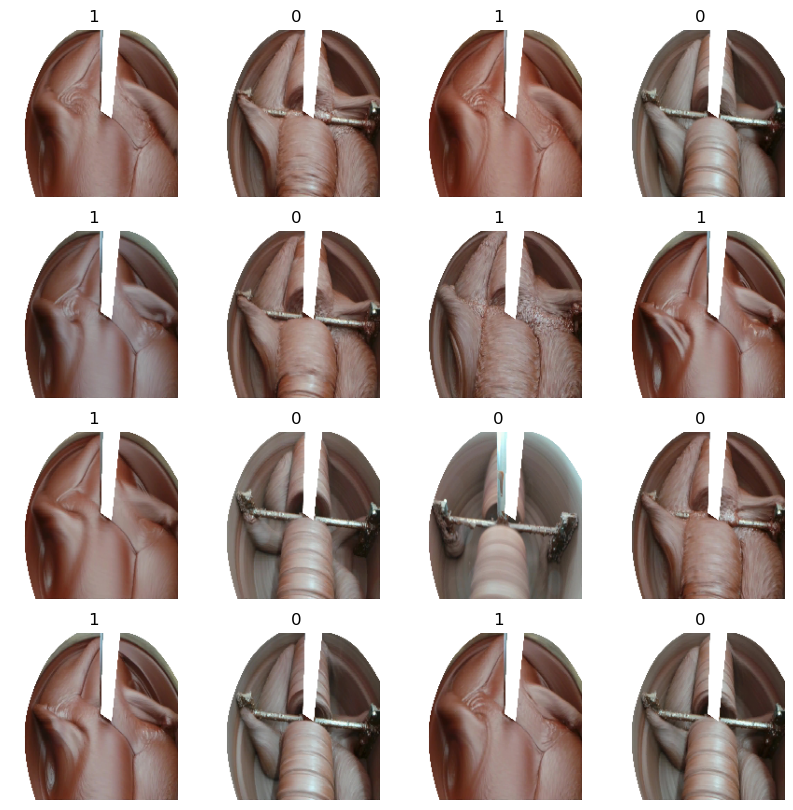

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
import pandas as pd
import numpy as np

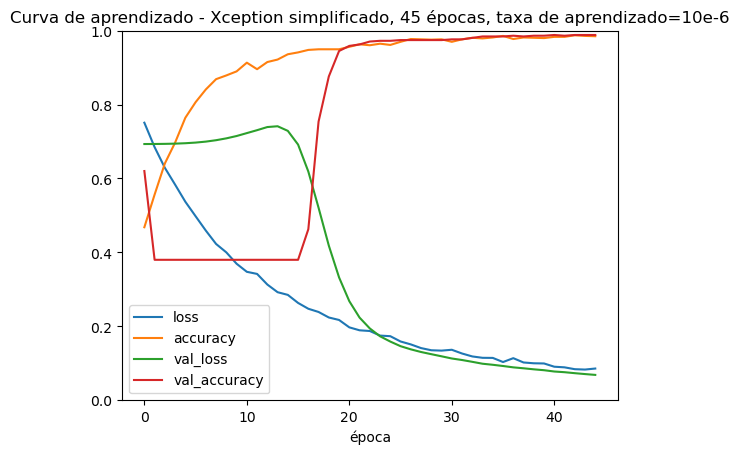

In [12]:
import pandas as pd
import numpy as np

historydf = pd.DataFrame(history.history, index=history.epoch)
learning_curve = historydf.plot(ylim=(0,1), title="Curva de aprendizado - Xception simplificado, 45 épocas, taxa de aprendizado=10e-6", xlabel="época")

In [7]:
model.evaluate(val_ds)

16/16 [==============================] - 10s 579ms/step - loss: 0.0685 - accuracy: 0.9882


[0.06852249801158905, 0.9881889820098877]

In [8]:
from sklearn.metrics import confusion_matrix

In [9]:
y_pred = model.predict(val_ds)

16/16 [==============================] - 10s 615ms/step


In [10]:
y_pred_class = y_pred > 0.5
y_pred_class = np.array(y_pred_class)
y_pred_class = np.reshape(y_pred_class, (508,))
print(y_pred_class.shape)

y = np.concatenate([y for x, y in val_ds], axis=0)
y = np.array(y)
print(y.shape)

(508,)
(508,)


In [11]:
def pretty_confusion_matrix(y_true, y_pred, labels=["False", "True"]):
    cm = confusion_matrix(y_true, y_pred)
    pred_labels = ['Julgou '+ l for l in labels]
    df = pd.DataFrame(cm, index=labels, columns=pred_labels)
    return df

pretty_confusion_matrix(y, y_pred_class, ['Pronto', 'Não pronto'])

,Julgou Pronto,Julgou Não pronto
Pronto,309,6
Não pronto,0,193


In [ ]:
model.save("trained_model_60epochs")

In [9]:
y_pred

array([[1.07600144e-05],
       [8.91407126e-06],
       [3.65082597e-05],
       [1.31007073e-05],
       [3.94825838e-06],
       [4.51682263e-06],
       [9.99995649e-01],
       [9.99988079e-01],
       [9.99932706e-01],
       [1.45483755e-05],
       [2.78141797e-05],
       [2.53079234e-05],
       [8.93022116e-06],
       [9.99986053e-01],
       [9.69332576e-01],
       [9.99987125e-01],
       [6.72788792e-06],
       [9.99988139e-01],
       [9.99987900e-01],
       [3.03757315e-06],
       [4.09181075e-06],
       [2.04090084e-05],
       [9.99988973e-01],
       [9.99983609e-01],
       [8.51553705e-06],
       [9.99777079e-01],
       [9.99943554e-01],
       [5.00054193e-06],
       [9.99990523e-01],
       [2.81027724e-06],
       [9.99995708e-01],
       [9.99998748e-01],
       [2.06039999e-06],
       [6.23319875e-06],
       [4.37223071e-06],
       [8.53219171e-06],
       [2.65169183e-06],
       [6.20415040e-06],
       [1.65854617e-05],
       [9.99996364e-01],
